In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures

In [3]:
data = pd.read_csv("Housing.csv")
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
# Strip any leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Correct target column name
target_col = "price"  # lowercase as per dataset


In [5]:
# Data Preprocessing
numeric_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(exclude=[np.number]).columns

# Fill missing numeric values with mean
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Fill missing categorical values with mode
for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# One-hot encode categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)


In [6]:
# Feature Selection

# Compute correlation matrix on numeric-only dataframe
corr_matrix = data_encoded.corr()

# Select features highly correlated with 'Price'
cor_threshold = 0.3
selected_features = corr_matrix['price'][abs(corr_matrix['price']) > cor_threshold].index.tolist()

# Remove target variable
if 'price' in selected_features:
    selected_features.remove('price')

X = data_encoded[selected_features].values
y = data_encoded['price'].values

print("Selected Features:", selected_features)


Selected Features: ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'airconditioning_yes', 'prefarea_yes']


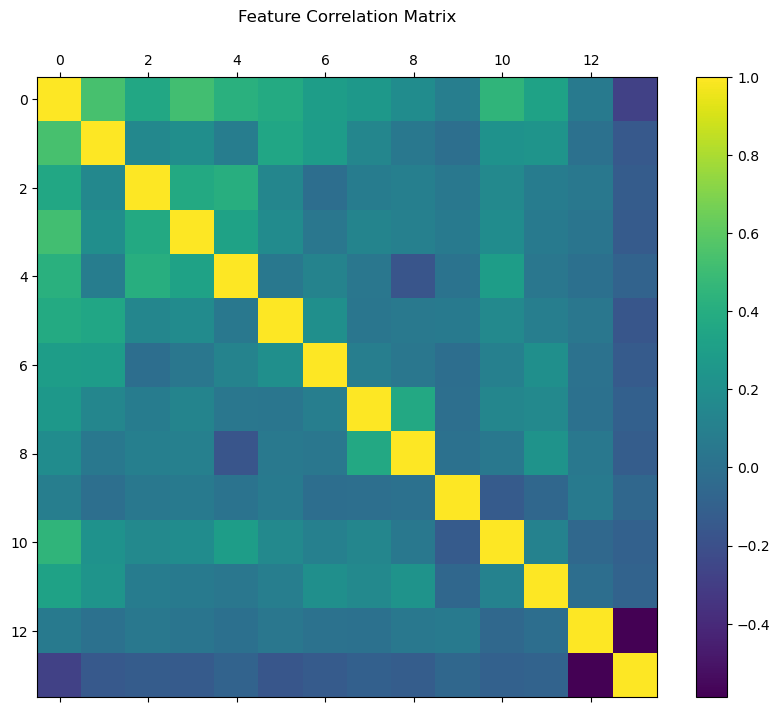

In [7]:
# Correlation Matrix Visualization
plt.figure(figsize=(10,8))
plt.matshow(corr_matrix, fignum=1)
plt.colorbar()
plt.title("Feature Correlation Matrix", pad=40)
plt.show()

In [8]:
def polynomial_features(X, degree=2):
    n_samples, n_features = X.shape
    X_poly = X.copy()
    
    # Squared and interaction terms
    for i in range(n_features):
        for j in range(i, n_features):
            X_poly = np.hstack((X_poly, (X[:, i] * X[:, j]).reshape(-1, 1)))
    
    if degree > 2:
        # Cubic terms
        for i in range(n_features):
            for j in range(i, n_features):
                for k in range(j, n_features):
                    X_poly = np.hstack((X_poly, (X[:, i] * X[:, j] * X[:, k]).reshape(-1,1)))
    
    return X_poly

In [10]:
# Automatic Polynomial Degree Selection + Gradient Descent
best_degree = 1
lowest_mse = float('inf')
best_theta = None
best_X_norm = None

for degree in range(1, 4):  # test degrees 1-3
    X_poly = polynomial_features(X, degree)
    X_poly = np.array(X_poly, dtype=float)  # ensure float type
    
    # Feature normalization
    X_mean = X_poly.mean(axis=0)
    X_std = X_poly.std(axis=0)
    X_std[X_std == 0] = 1  # avoid division by zero

    X_norm = (X_poly - X_mean) / X_std
    X_norm = np.c_[np.ones(X_norm.shape[0]), X_norm]  # add bias term
    
    # Gradient descent
    theta = gradient_descent(X_norm, y, lr=0.01, iterations=5000)
    
    # Predictions and MSE
    predictions = X_norm.dot(theta)
    mse = np.mean((predictions - y)**2)
    
    print(f"Degree {degree} => MSE: {mse}")
    
    if mse < lowest_mse:
        lowest_mse = mse
        best_degree = degree
        best_theta = theta
        best_X_norm = X_norm

print(f"Best Polynomial Degree: {best_degree}, Lowest MSE: {lowest_mse}")


Degree 1 => MSE: 1149302396308.1833
Degree 2 => MSE: 1149302396308.1833
Degree 3 => MSE: 1066098421927.7169
Best Polynomial Degree: 3, Lowest MSE: 1066098421927.7169


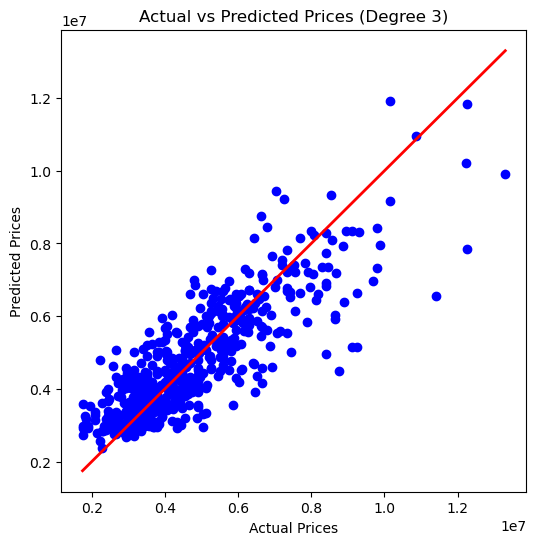

Mean Squared Error: 1066098421927.7169


In [11]:
#  Predictions and Evaluation
predictions = best_X_norm.dot(best_theta)

plt.figure(figsize=(6,6))
plt.scatter(y, predictions, color='blue')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title(f"Actual vs Predicted Prices (Degree {best_degree})")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2)
plt.show()

# Mean Squared Error
mse = np.mean((predictions - y)**2)
print("Mean Squared Error:", mse)

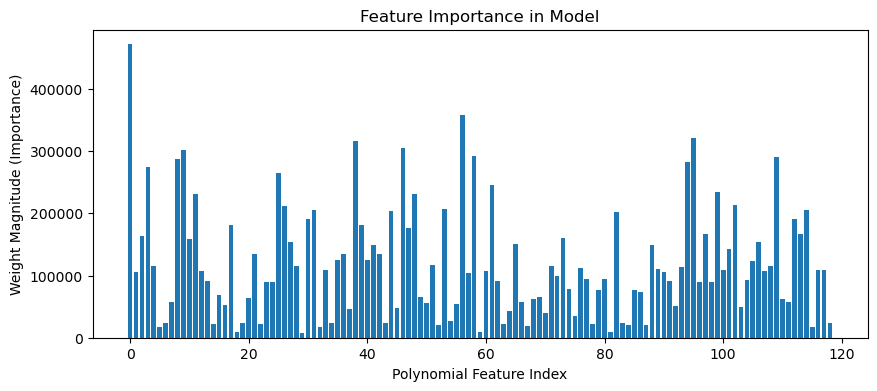

In [12]:
# Feature Importance Visualization
feature_weights = best_theta[1:]  # exclude bias term
plt.figure(figsize=(10,4))
plt.bar(range(len(feature_weights)), np.abs(feature_weights))
plt.xlabel("Polynomial Feature Index")
plt.ylabel("Weight Magnitude (Importance)")
plt.title("Feature Importance in Model")
plt.show()


In [13]:
#Compare Actual vs Predicted (first 10 rows)
comparison = pd.DataFrame({"Actual": y[:10], "Predicted": predictions[:10]})
comparison

,Actual,Predicted
0,13300000,9.915914e+06
1,12250000,1.184239e+07
2,12250000,7.853288e+06
3,12215000,1.021916e+07
4,11410000,6.543212e+06
5,10850000,1.095750e+07
6,10150000,1.192672e+07
7,10150000,9.160199e+06
8,9870000,7.952217e+06
9,9800000,8.416526e+06


In [ ]:
# Predict New House Price (Improved for Yes/No features)

# Example: start with partial dictionary
new_house = {
    "Size": 2500,
    "Bedrooms": 4,
    # others can be left out, it will ask
}

for feature in selected_features:
    if feature not in new_house:
        user_input = input(f"Enter value for {feature}: ")

        # Handle yes/no categorical features
        if user_input.lower() in ["yes", "y", "1"]:
            value = 1.0
        elif user_input.lower() in ["no", "n", "0"]:
            value = 0.0
        else:
            value = float(user_input)  # numeric feature

        new_house[feature] = value

# Convert to array in correct order
new_X = np.array([new_house[feature] for feature in selected_features]).reshape(1, -1)

# Expand polynomial features (use best_degree)
new_X_poly = polynomial_features(new_X, degree=best_degree)

# Normalize using training data mean and std
new_X_norm = (new_X_poly - X_mean) / X_std

# Add bias term
new_X_norm = np.c_[np.ones(new_X_norm.shape[0]), new_X_norm]

# Predict price
predicted_price = new_X_norm.dot(best_theta)[0]
print("\n✅ New house features:", new_house)
print(f"💰 Predicted House Price: {predicted_price:.2f}")
